In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU

In [2]:
df = pd.read_csv('hcorrect1.csv')
df.head(1)

,Date,Temperature,Sunshine Duration,Relative Humidity,Shortwave Radiation,Direct Shortwave Radiation,Diffuse Shortwave Radiation,Precipitation Total,Cloud Cover Total,Mean Sea level Pressure,Wind speed,Solar energy
0,01-01-2018,26.983492,0.449684,57.692308,309.942498,186.694343,123.248154,0.0,49.461538,1010.2,10.362319,197578


In [3]:
# Assuming 'Date' column is in df dataframe
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [4]:
df.isnull().sum()

Date                           0
Temperature                    0
Sunshine Duration              0
Relative Humidity              0
Shortwave Radiation            0
Direct Shortwave Radiation     0
Diffuse Shortwave Radiation    0
Precipitation Total            0
Cloud Cover Total              0
Mean Sea level Pressure        0
Wind speed                     0
Solar energy                   0
dtype: int64

In [5]:
df.describe()

,Date,Temperature,Sunshine Duration,Relative Humidity,Shortwave Radiation,Direct Shortwave Radiation,Diffuse Shortwave Radiation,Precipitation Total,Cloud Cover Total,Mean Sea level Pressure,Wind speed,Solar energy
count,1563,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000
mean,2020-02-21 00:00:00,30.506449,0.543860,58.813770,422.823498,257.347041,165.476454,0.113657,41.621615,1008.436586,14.491938,198807.699936
min,2018-01-01 00:00:00,18.684261,0.000000,18.307692,37.750833,-0.164323,37.915156,0.000000,0.000000,995.900000,2.220750,0.000000
25%,2019-01-26 12:00:00,27.859261,0.249614,50.230769,326.184995,159.212901,150.399596,0.000000,15.665385,1004.523077,9.413881,165435.500000
50%,2020-02-21 00:00:00,30.009645,0.666753,57.461538,451.378331,288.139873,168.384178,0.000000,30.000000,1008.830769,14.019829,209321.000000
75%,2021-03-17 12:00:00,33.080799,0.793371,66.384615,539.970412,360.701348,185.201046,0.061538,71.000001,1012.211538,19.389128,242018.000000
max,2022-04-12 00:00:00,42.166569,0.993761,95.692308,640.132493,420.830998,219.301491,8.207692,100.000000,1018.600000,32.838716,322087.000000
std,NaN,3.415098,0.309052,12.612190,143.285495,124.864645,26.684175,0.392285,32.662539,4.447436,6.302058,57768.209806


In [6]:
# Select the columns you wish to standardize
columns_to_standardize = ['Temperature', 'Sunshine Duration', 'Relative Humidity']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

# Now, df will have the selected features standardized
df.head()


,Date,Temperature,Sunshine Duration,Relative Humidity,Shortwave Radiation,Direct Shortwave Radiation,Diffuse Shortwave Radiation,Precipitation Total,Cloud Cover Total,Mean Sea level Pressure,Wind speed,Solar energy
0,2018-01-01,-1.031913,-0.304825,-0.088947,309.942498,186.694343,123.248154,0.0,49.461538,1010.200000,10.362319,197578
1,2018-01-02,-0.679068,0.346531,-0.394000,419.189997,268.350369,150.839628,0.0,29.230769,1010.100000,11.991167,205219
2,2018-01-03,-0.920832,0.258895,-0.692952,427.719166,274.224414,153.494753,0.0,32.307692,1012.161538,9.485070,210626
3,2018-01-04,-0.968599,0.444607,-0.784468,419.931663,272.142339,147.789320,0.0,26.523077,1013.115385,7.593981,211361
4,2018-01-05,-1.246865,1.038475,-0.686851,458.720828,287.111508,171.609316,0.0,0.076923,1011.376923,7.879314,215376


In [7]:
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df = pd.get_dummies(df, columns=['Month', 'DayOfWeek'], drop_first=True)

# Step 2: Feature Engineering
df['Clearness_Index'] = df['Direct Shortwave Radiation'] / df['Shortwave Radiation']

# Step 3: Correlation Analysis
correlation_matrix = df.corr()
target_correlation = correlation_matrix['Solar energy'].sort_values()

df.head()

,Date,Temperature,Sunshine Duration,Relative Humidity,Shortwave Radiation,Direct Shortwave Radiation,Diffuse Shortwave Radiation,Precipitation Total,Cloud Cover Total,Mean Sea level Pressure,...,Month_10,Month_11,Month_12,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Clearness_Index
0,2018-01-01,-1.031913,-0.304825,-0.088947,309.942498,186.694343,123.248154,0.0,49.461538,1010.200000,...,False,False,False,False,False,False,False,False,False,0.602352
1,2018-01-02,-0.679068,0.346531,-0.394000,419.189997,268.350369,150.839628,0.0,29.230769,1010.100000,...,False,False,False,True,False,False,False,False,False,0.640164
2,2018-01-03,-0.920832,0.258895,-0.692952,427.719166,274.224414,153.494753,0.0,32.307692,1012.161538,...,False,False,False,False,True,False,False,False,False,0.641132
3,2018-01-04,-0.968599,0.444607,-0.784468,419.931663,272.142339,147.789320,0.0,26.523077,1013.115385,...,False,False,False,False,False,True,False,False,False,0.648063
4,2018-01-05,-1.246865,1.038475,-0.686851,458.720828,287.111508,171.609316,0.0,0.076923,1011.376923,...,False,False,False,False,False,False,True,False,False,0.625896


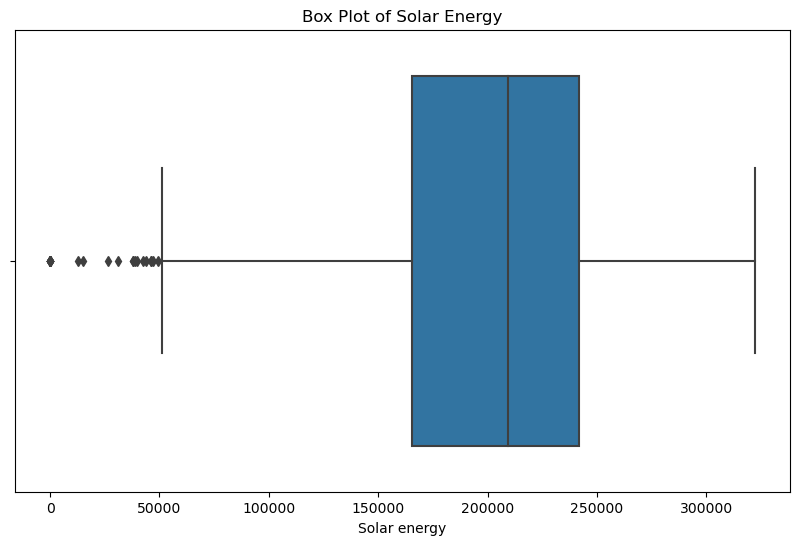

(25, 1.599488163787588)

In [8]:
# Visualizing 'Solar energy' distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Solar energy'])
plt.title('Box Plot of Solar Energy')
plt.show()

# Calculate IQR
Q1 = df['Solar energy'].quantile(0.25)
Q3 = df['Solar energy'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = df[(df['Solar energy'] < (Q1 - 1.5 * IQR)) | (df['Solar energy'] > (Q3 + 1.5 * IQR))]['Solar energy']

# Display outlier counts
outlier_count = outliers.count()
total_count = df['Solar energy'].count()
outlier_percentage = (outlier_count / total_count) * 100

outlier_count, outlier_percentage


In [9]:
# Capping outliers
cap_lower = Q1 - 1.5 * IQR
cap_upper = Q3 + 1.5 * IQR

df['Solar energy Capped'] = df['Solar energy'].apply(lambda x: max(min(x, cap_upper), cap_lower))
df.head()

,Date,Temperature,Sunshine Duration,Relative Humidity,Shortwave Radiation,Direct Shortwave Radiation,Diffuse Shortwave Radiation,Precipitation Total,Cloud Cover Total,Mean Sea level Pressure,...,Month_11,Month_12,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Clearness_Index,Solar energy Capped
0,2018-01-01,-1.031913,-0.304825,-0.088947,309.942498,186.694343,123.248154,0.0,49.461538,1010.200000,...,False,False,False,False,False,False,False,False,0.602352,197578.0
1,2018-01-02,-0.679068,0.346531,-0.394000,419.189997,268.350369,150.839628,0.0,29.230769,1010.100000,...,False,False,True,False,False,False,False,False,0.640164,205219.0
2,2018-01-03,-0.920832,0.258895,-0.692952,427.719166,274.224414,153.494753,0.0,32.307692,1012.161538,...,False,False,False,True,False,False,False,False,0.641132,210626.0
3,2018-01-04,-0.968599,0.444607,-0.784468,419.931663,272.142339,147.789320,0.0,26.523077,1013.115385,...,False,False,False,False,True,False,False,False,0.648063,211361.0
4,2018-01-05,-1.246865,1.038475,-0.686851,458.720828,287.111508,171.609316,0.0,0.076923,1011.376923,...,False,False,False,False,False,True,False,False,0.625896,215376.0


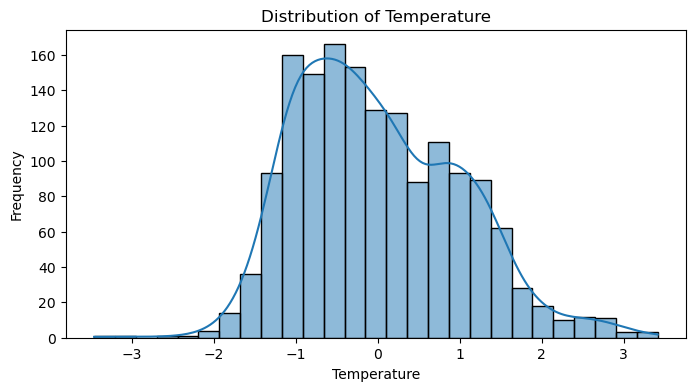

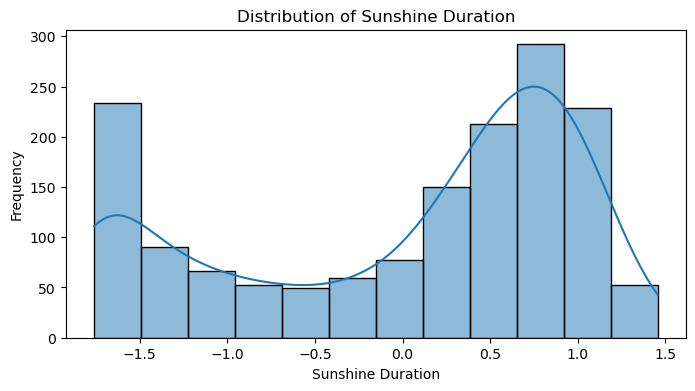

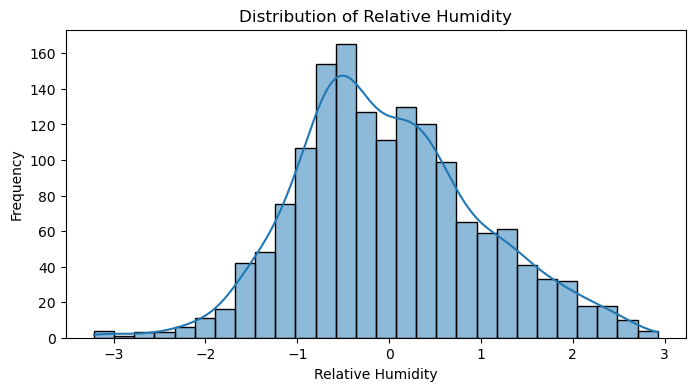

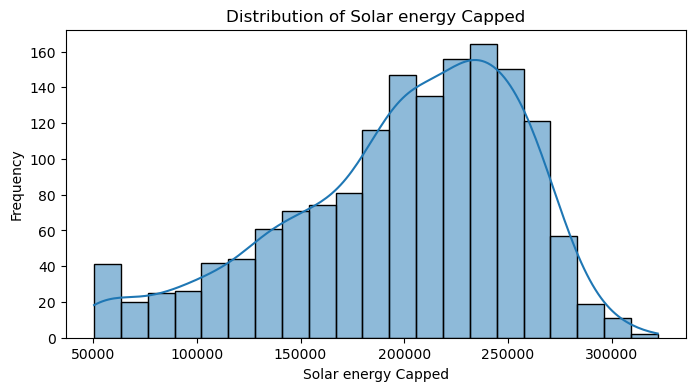

In [10]:
# Histograms for continuous features
for column in ['Temperature', 'Sunshine Duration', 'Relative Humidity', 'Solar energy Capped']:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


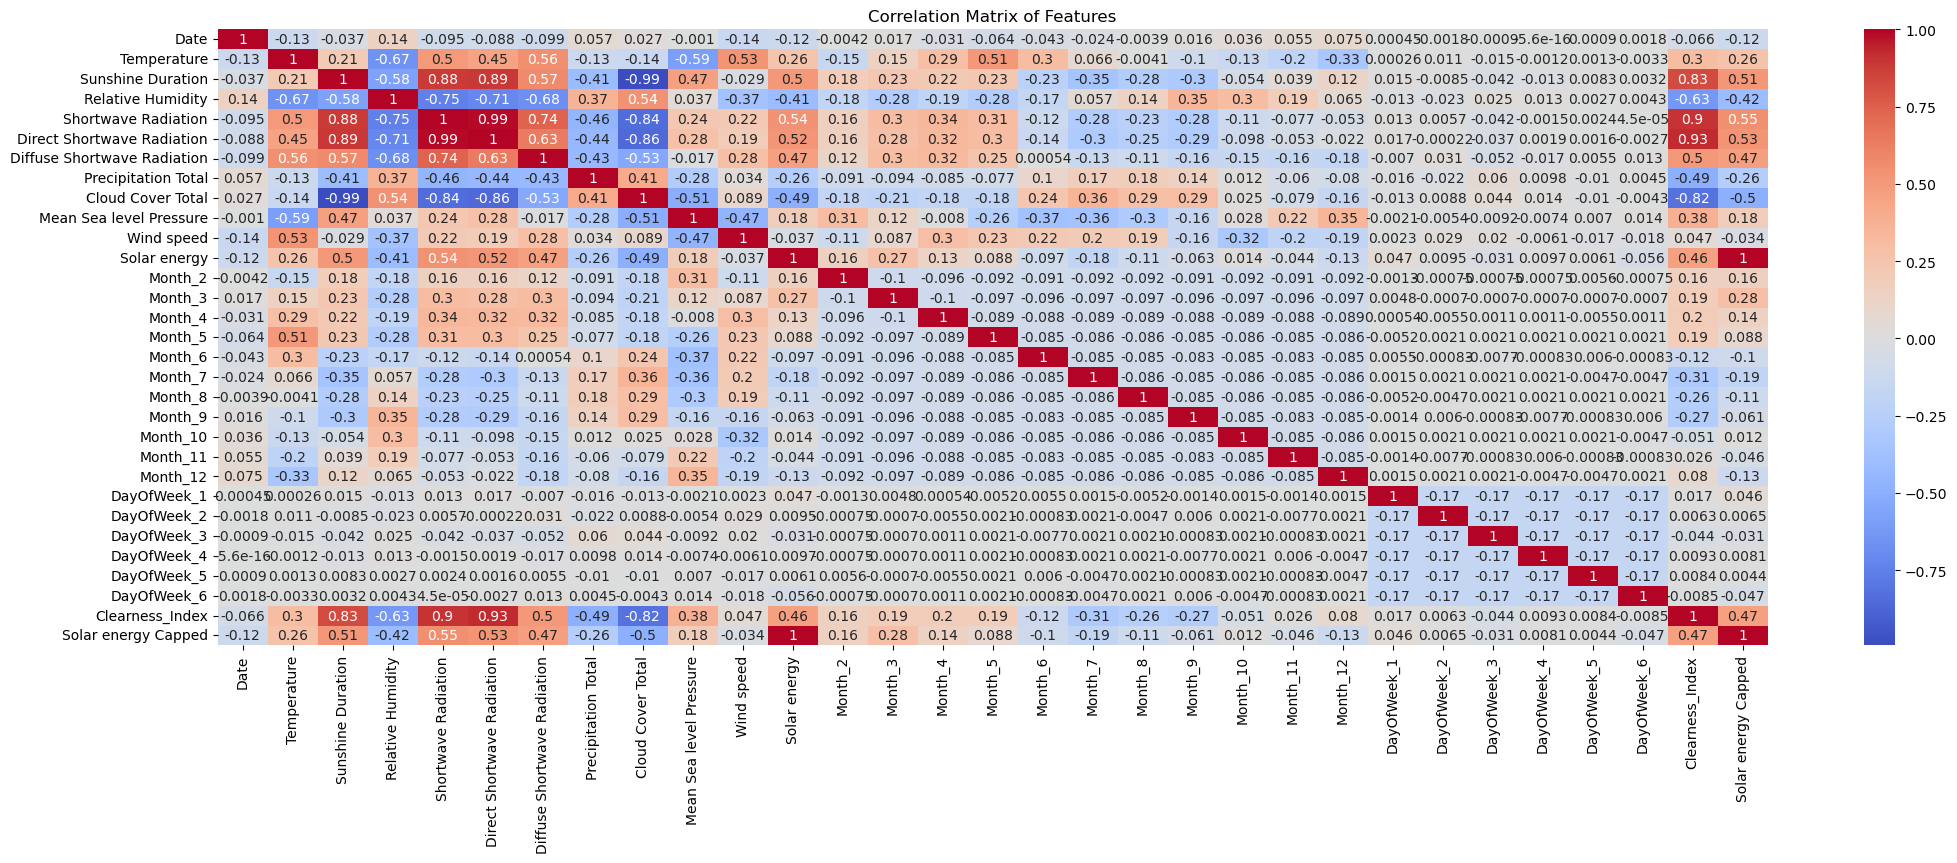

In [11]:
# Correlation matrix
corr_matrix = df.corr()

# Visualizing the correlation matrix
plt.figure(figsize=(25, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

C:\Users\ajayb\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


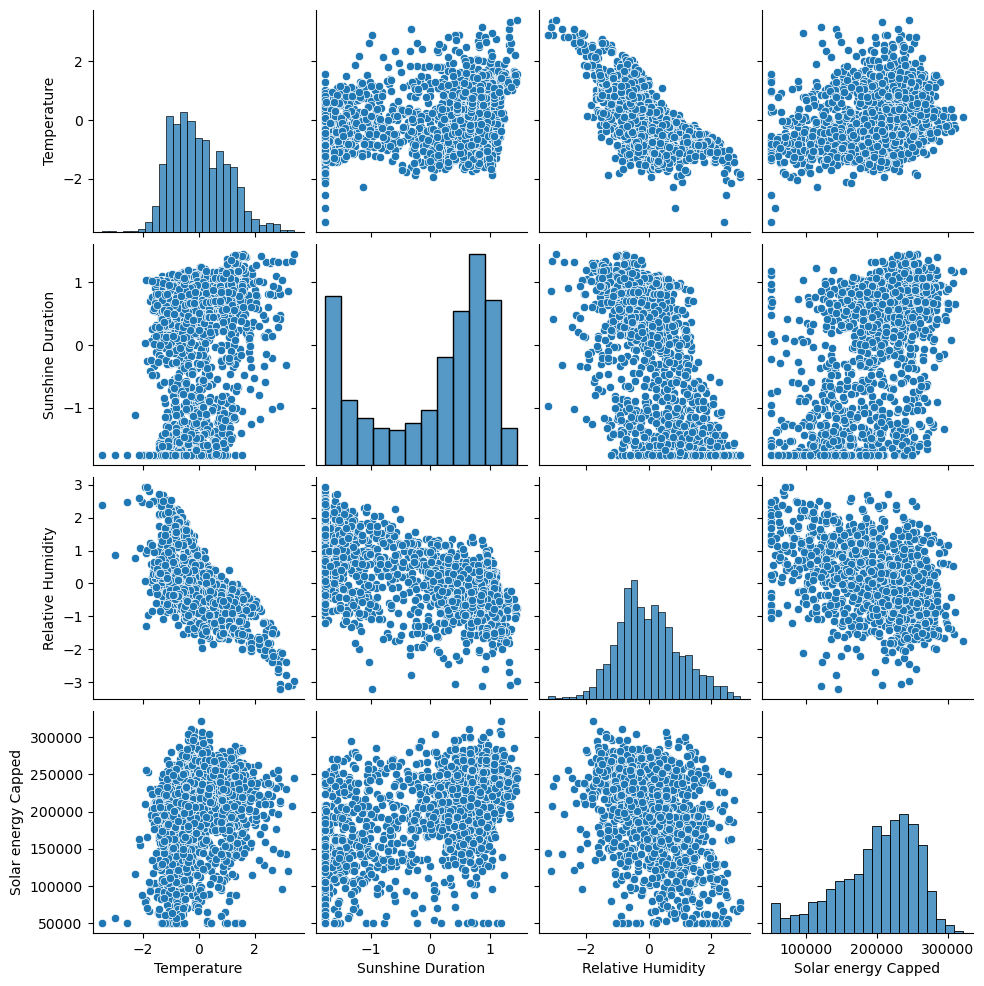

In [12]:
# Pair plot for selected features and the target variable
sns.pairplot(df[['Temperature', 'Sunshine Duration', 'Relative Humidity', 'Solar energy Capped']])
plt.show()

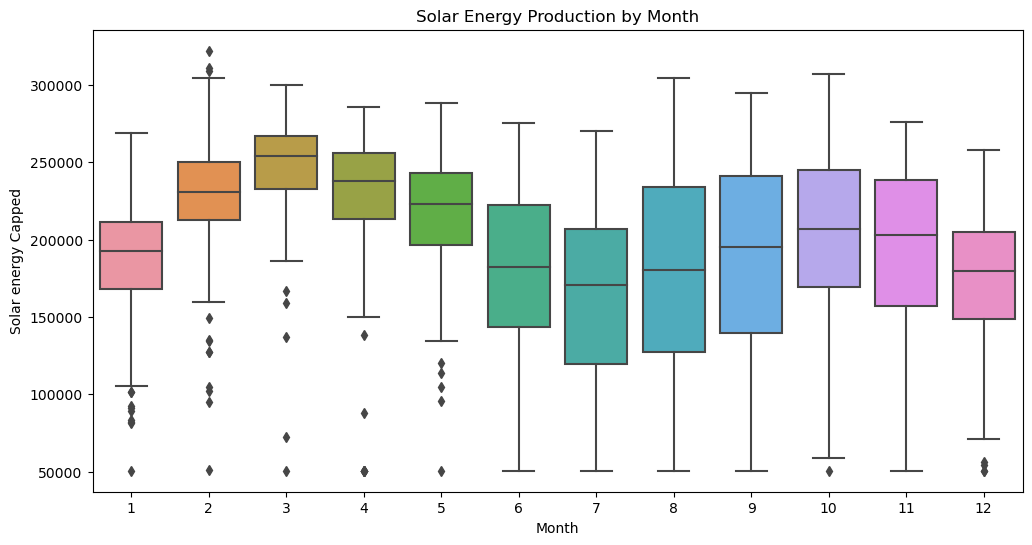

In [13]:
df['Month'] = df['Date'].dt.month.astype('category')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Solar energy Capped', data=df)
plt.title('Solar Energy Production by Month')
plt.show()

# df['Month'] = df['Date'].dt.month
# df['DayOfWeek'] = df['Date'].dt.dayofweek
# df = pd.get_dummies(df, columns=['Month', 'DayOfWeek'], drop_first=True)

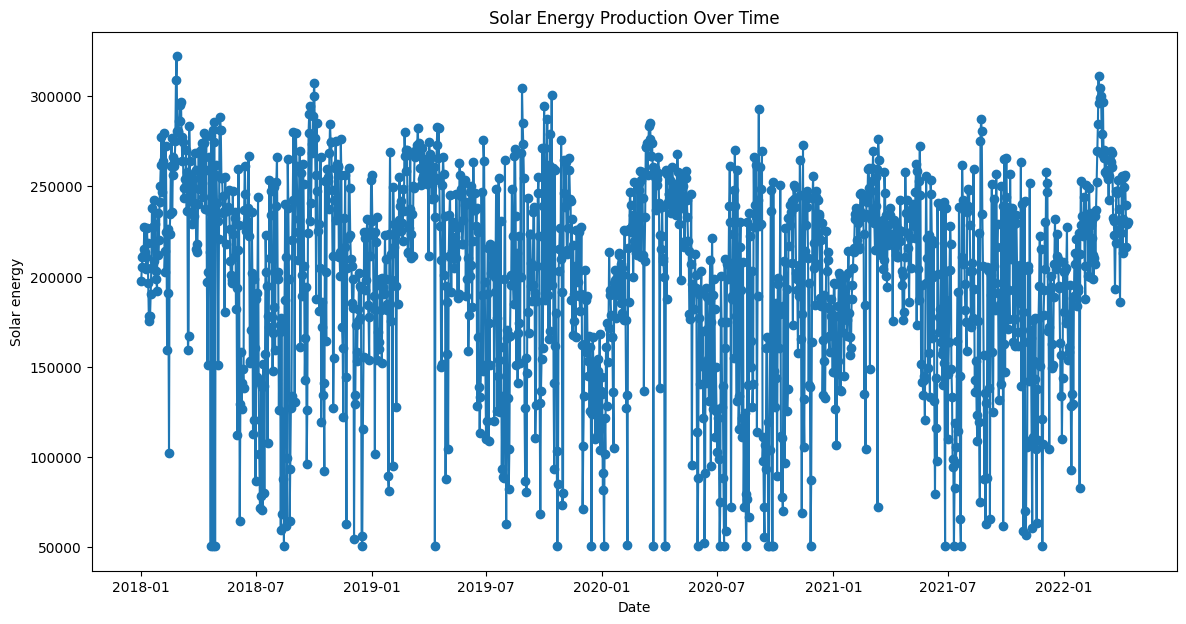

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Solar energy Capped'], marker='o', linestyle='-')
plt.title('Solar Energy Production Over Time')
plt.xlabel('Date')
plt.ylabel('Solar energy')
plt.show()

In [14]:
# dropping date column
df.drop('Date', axis=1, inplace=True)
# Split the dataset using TimeSeriesSplit
X = np.array(df.drop('Solar energy Capped', axis=1))
y = np.array(df['Solar energy Capped'])

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Train your model on X_train, y_train and evaluate it on X_test, y_test
    # Model training and evaluation code here
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(1303, 30) (260, 30)
(1303,) (260,)


In [15]:
# # dropping date column
# df.drop('Date', axis=1, inplace=True)
# X = np.array(df.drop('Solar energy Capped', axis=1))
# y = np.array(df['Solar energy Capped'])
# split_index = int(len(df) * 0.8)
# X_train, X_test = X[:split_index], X[split_index:]
# y_train, y_test = y[:split_index], y[split_index:]

In [15]:
df.head()

,Temperature,Sunshine Duration,Relative Humidity,Shortwave Radiation,Direct Shortwave Radiation,Diffuse Shortwave Radiation,Precipitation Total,Cloud Cover Total,Mean Sea level Pressure,Wind speed,...,Month_12,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Clearness_Index,Solar energy Capped,Month
0,-1.031913,-0.304825,-0.088947,309.942498,186.694343,123.248154,0.0,49.461538,1010.200000,10.362319,...,False,False,False,False,False,False,False,0.602352,197578.0,1
1,-0.679068,0.346531,-0.394000,419.189997,268.350369,150.839628,0.0,29.230769,1010.100000,11.991167,...,False,True,False,False,False,False,False,0.640164,205219.0,1
2,-0.920832,0.258895,-0.692952,427.719166,274.224414,153.494753,0.0,32.307692,1012.161538,9.485070,...,False,False,True,False,False,False,False,0.641132,210626.0,1
3,-0.968599,0.444607,-0.784468,419.931663,272.142339,147.789320,0.0,26.523077,1013.115385,7.593981,...,False,False,False,True,False,False,False,0.648063,211361.0,1
4,-1.246865,1.038475,-0.686851,458.720828,287.111508,171.609316,0.0,0.076923,1011.376923,7.879314,...,False,False,False,False,True,False,False,0.625896,215376.0,1


In [17]:
# low level models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net Regression": ElasticNet()
}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{name} Performance:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MSE: {mse}")
    print(f"R2 Score: {r2}\n")

Linear Regression Performance:
MAE: 1553.15912696905
RMSE: 1997.2526242411973
MSE: 3989018.0450383495
R2 Score: 0.9986332982717682

Ridge Regression Performance:
MAE: 1550.1513390078815
RMSE: 1998.3215563393073
MSE: 3993289.042530352
R2 Score: 0.998631834959347

Lasso Regression Performance:
MAE: 1551.6495274425222
RMSE: 1998.162995770804
MSE: 3992655.3576677535
R2 Score: 0.9986320520699711

Elastic Net Regression Performance:
MAE: 1424.722536262998
RMSE: 1862.90688095111
MSE: 3470422.047094993
R2 Score: 0.9988109776000241



C:\Users\ajayb\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.111e+10, tolerance: 4.198e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\ajayb\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.084e+10, tolerance: 4.198e+08
  model = cd_fast.enet_coordinate_descent(


In [18]:
# random forest
# Initialize the Random Forest Regressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the performance metrics
print("Random Forest Performance:")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"R^2 Score: {r2_rf}")


Random Forest Performance:
Mean Absolute Error (MAE): 225.0560384615396
Mean Squared Error (MSE): 460267.6014642307
Root Mean Squared Error (RMSE): 678.430248046349
R^2 Score: 0.9998423049183363


In [19]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R2 Score: {r2}")


In [20]:
# Reshape X_train and X_test for LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Convert X_train_reshaped to a numeric data type (assuming X_train_reshaped is a numpy array)
X_train_reshaped = X_train_reshaped.astype(np.float64)

# Check data types and missing values
print("Data type of X_train_reshaped:", X_train_reshaped.dtype)
print("Data type of y_train:", y_train.dtype)

# Check for missing values in X_train_reshaped
if np.isnan(X_train_reshaped).any():
    print("X_train_reshaped contains missing values.")
else:
    print("No missing values in X_train_reshaped.")

# Check for missing values in y_train (assuming y_train is a numpy array)
if np.isnan(y_train).any():
    print("y_train contains missing values.")
else:
    print("No missing values in y_train.")

# Define the LSTM model with corrected input_shape
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Now, use the reshaped versions for training
lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=2)

# Predict
y_pred_lstm = lstm_model.predict(X_test_reshaped)

# Evaluate the model
mse_lstm = mean_squared_error(y_test, y_pred_lstm.flatten())
mae_lstm = mean_absolute_error(y_test, y_pred_lstm.flatten())
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm.flatten())

print("Mean Squared Error (MSE) of LSTM Model:", mse_lstm)
print("Mean Absolute Error (MAE) of LSTM Model:", mae_lstm)
print("Root Mean Squared Error (RMSE) of LSTM Model:", rmse_lstm)
print("R2 Score of LSTM Model:", r2_lstm)


Data type of X_train_reshaped: float64
Data type of y_train: float64
No missing values in X_train_reshaped.
No missing values in y_train.
Epoch 1/20
41/41 - 1s - loss: 40976572416.0000 - 1s/epoch - 34ms/step
Epoch 2/20
41/41 - 0s - loss: 38086828032.0000 - 240ms/epoch - 6ms/step
Epoch 3/20
41/41 - 0s - loss: 34079875072.0000 - 255ms/epoch - 6ms/step
Epoch 4/20
41/41 - 0s - loss: 28884340736.0000 - 234ms/epoch - 6ms/step
Epoch 5/20
41/41 - 0s - loss: 22961379328.0000 - 285ms/epoch - 7ms/step
Epoch 6/20
41/41 - 0s - loss: 16965093376.0000 - 255ms/epoch - 6ms/step
Epoch 7/20
41/41 - 0s - loss: 11475497984.0000 - 258ms/epoch - 6ms/step
Epoch 8/20
41/41 - 0s - loss: 7042765824.0000 - 210ms/epoch - 5ms/step
Epoch 9/20
41/41 - 0s - loss: 3872541952.0000 - 240ms/epoch - 6ms/step
Epoch 10/20
41/41 - 0s - loss: 1881683072.0000 - 225ms/epoch - 5ms/step
Epoch 11/20
41/41 - 0s - loss: 813414336.0000 - 211ms/epoch - 5ms/step
Epoch 12/20
41/41 - 0s - loss: 318424224.0000 - 210ms/epoch - 5ms/step
Epoc

In [ ]:
print("X_train_reshaped dtype:", X_train_reshaped.dtype)
print("X_train_reshaped shape:", X_train_reshaped.shape)
print("X_test_reshaped dtype:", X_test_reshaped.dtype)
print("X_test_reshaped shape:", X_test_reshaped.shape)


In [ ]:
print("LSTM Model Input Shape:", lstm_model.input_shape)


In [22]:
import numpy as np

# Convert data type to float32
X_train_reshaped = X_train_reshaped.astype(np.float32)
X_test_reshaped = X_test_reshaped.astype(np.float32)

# Verify the data types
print("X_train_reshaped dtype after conversion:", X_train_reshaped.dtype)
print("X_test_reshaped dtype after conversion:", X_test_reshaped.dtype)


X_train_reshaped dtype after conversion: float32
X_test_reshaped dtype after conversion: float32


In [24]:
bi_lstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(1)
])
bi_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
bi_lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=2)

# Predict and Evaluate
y_pred_bi_lstm = bi_lstm_model.predict(X_test_reshaped)
evaluate_model(y_test, y_pred_bi_lstm.flatten())

Epoch 1/20
41/41 - 3s - loss: 46914396160.0000 - 3s/epoch - 62ms/step
Epoch 2/20
41/41 - 0s - loss: 38870081536.0000 - 420ms/epoch - 10ms/step
Epoch 3/20
41/41 - 0s - loss: 30934462464.0000 - 465ms/epoch - 11ms/step
Epoch 4/20
41/41 - 0s - loss: 22530150400.0000 - 450ms/epoch - 11ms/step
Epoch 5/20
41/41 - 0s - loss: 14497656832.0000 - 442ms/epoch - 11ms/step
Epoch 6/20
41/41 - 0s - loss: 8072705024.0000 - 441ms/epoch - 11ms/step
Epoch 7/20
41/41 - 0s - loss: 3746964480.0000 - 445ms/epoch - 11ms/step
Epoch 8/20
41/41 - 0s - loss: 1407999232.0000 - 466ms/epoch - 11ms/step
Epoch 9/20
41/41 - 0s - loss: 428146624.0000 - 430ms/epoch - 10ms/step
Epoch 10/20
41/41 - 0s - loss: 116671984.0000 - 405ms/epoch - 10ms/step
Epoch 11/20
41/41 - 0s - loss: 39018092.0000 - 481ms/epoch - 12ms/step
Epoch 12/20
41/41 - 0s - loss: 23564232.0000 - 450ms/epoch - 11ms/step
Epoch 13/20
41/41 - 0s - loss: 20718276.0000 - 436ms/epoch - 11ms/step
Epoch 14/20
41/41 - 0s - loss: 19951972.0000 - 475ms/epoch - 12ms/

In [25]:
# Define the GRU model
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(1)
])
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
gru_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=2)

# Predict and Evaluate
y_pred_gru = gru_model.predict(X_test_reshaped)
evaluate_model(y_test, y_pred_gru.flatten())  # Assuming evaluate_model is defined


Epoch 1/20
41/41 - 2s - loss: 39467614208.0000 - 2s/epoch - 41ms/step
Epoch 2/20
41/41 - 0s - loss: 22867460096.0000 - 295ms/epoch - 7ms/step
Epoch 3/20
41/41 - 0s - loss: 12493560832.0000 - 291ms/epoch - 7ms/step
Epoch 4/20
41/41 - 0s - loss: 5608037376.0000 - 255ms/epoch - 6ms/step
Epoch 5/20
41/41 - 0s - loss: 1902292736.0000 - 240ms/epoch - 6ms/step
Epoch 6/20
41/41 - 0s - loss: 454190080.0000 - 286ms/epoch - 7ms/step
Epoch 7/20
41/41 - 0s - loss: 88565696.0000 - 270ms/epoch - 7ms/step
Epoch 8/20
41/41 - 0s - loss: 29971586.0000 - 270ms/epoch - 7ms/step
Epoch 9/20
41/41 - 0s - loss: 23796314.0000 - 270ms/epoch - 7ms/step
Epoch 10/20
41/41 - 0s - loss: 23225100.0000 - 270ms/epoch - 7ms/step
Epoch 11/20
41/41 - 0s - loss: 22986586.0000 - 255ms/epoch - 6ms/step
Epoch 12/20
41/41 - 0s - loss: 22759908.0000 - 255ms/epoch - 6ms/step
Epoch 13/20
41/41 - 0s - loss: 22522454.0000 - 270ms/epoch - 7ms/step
Epoch 14/20
41/41 - 0s - loss: 22289242.0000 - 285ms/epoch - 7ms/step
Epoch 15/20
41/41

C:\Users\ajayb\anaconda3\envs\tensorflowgpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.092e+10, tolerance: 4.198e+08
  model = cd_fast.enet_coordinate_descent(


9/9 [==============================] - 0s 3ms/step


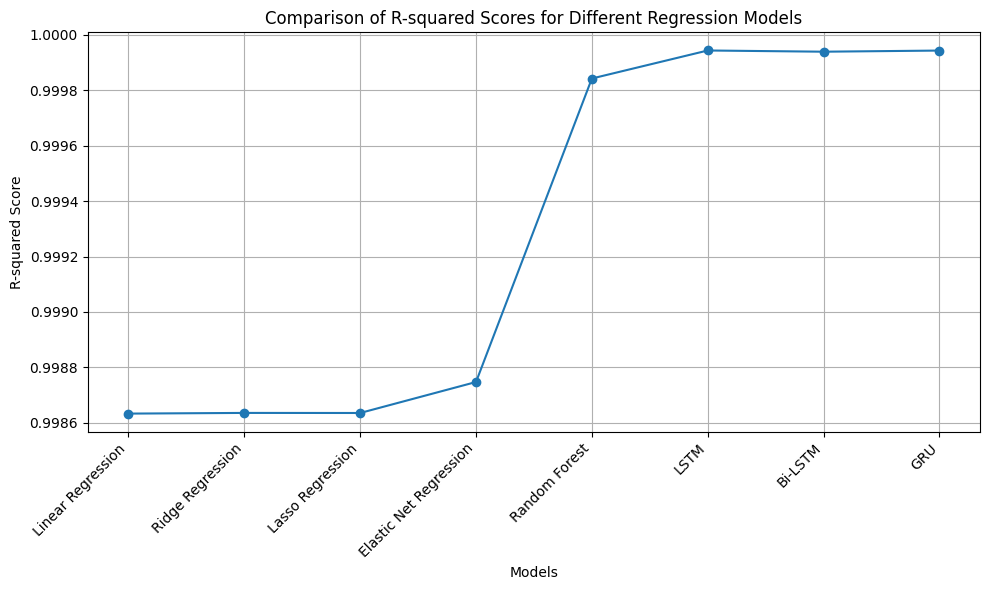

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, GRU
from keras.optimizers import Adam

# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net Regression": ElasticNet(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LSTM": Sequential([
        LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
        Dense(1)
    ]),
    "Bi-LSTM": Sequential([
        Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
        Dense(1)
    ]),
    "GRU": Sequential([
        GRU(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
        Dense(1)
    ])
}

# Initialize lists to store model names and R-squared scores
model_names = []
r2_scores = []

# Train and evaluate each model
for name, model in models.items():
    # Train the model (excluding LSTM, Bi-LSTM, and GRU)
    if name not in ["LSTM", "Bi-LSTM", "GRU"]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
    else:
        # Train the LSTM, Bi-LSTM, and GRU models
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=0)
        y_pred = model.predict(X_test_reshaped)
        r2 = r2_score(y_test, y_pred)

    # Append model name and R-squared score to lists
    model_names.append(name)
    r2_scores.append(r2)

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(model_names, r2_scores, marker='o')
plt.xlabel('Models')
plt.ylabel('R-squared Score')
plt.title('Comparison of R-squared Scores for Different Regression Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
print(r2_scores)

In [ ]:
import matplotlib.pyplot as plt

# Define the LSTM model with corrected input_shape
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the LSTM model
lstm_history = lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_test_reshaped, y_test))

# Plot the training and validation loss for LSTM
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Define the Bi-LSTM model
bi_lstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(1)
])
bi_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the Bi-LSTM model
bi_lstm_history = bi_lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_test_reshaped, y_test))

# Plot the training and validation loss for Bi-LSTM
plt.plot(bi_lstm_history.history['loss'], label='Training Loss')
plt.plot(bi_lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Bi-LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Define the GRU model
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(1)
])
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the GRU model
gru_history = gru_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_test_reshaped, y_test))

# Plot the training and validation loss for GRU
plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Define the LSTM model with corrected input_shape
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the LSTM model
lstm_history = lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_test_reshaped, y_test))

# Define the Bi-LSTM model
bi_lstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(1)
])
bi_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the Bi-LSTM model
bi_lstm_history = bi_lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_test_reshaped, y_test))

# Define the GRU model
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(1)
])
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the GRU model
gru_history = gru_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_test_reshaped, y_test))

# Plot the training and validation loss for all models
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss', color='blue', linestyle='-')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss', color='blue', linestyle='--')
plt.plot(bi_lstm_history.history['loss'], label='Bi-LSTM Training Loss', color='green', linestyle='-')
plt.plot(bi_lstm_history.history['val_loss'], label='Bi-LSTM Validation Loss', color='green', linestyle='--')
plt.plot(gru_history.history['loss'], label='GRU Training Loss', color='red', linestyle='-')
plt.plot(gru_history.history['val_loss'], label='GRU Validation Loss', color='red', linestyle='--')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# this is cross validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define regression models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net Regression": ElasticNet(),
    "Support Vector Regression": SVR()
}

# Evaluation metrics
evaluation_metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

# Evaluate each model using cross-validation
for name, model in models.items():
    print(f"\n{name}:")
    for metric in evaluation_metrics:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring=metric)
        if metric == 'r2':
            print(f"R2 Score: Mean R2 Score: {scores.mean():.7f}, Std R2 Score: {scores.std():.7f}")
        elif metric == 'neg_mean_squared_error':
            rmse_scores = np.sqrt(-scores)
            print(f"{metric[4:].replace('_', ' ').title()}: Mean RMSE: {rmse_scores.mean():.7f}, Std RMSE: {rmse_scores.std():.7f}")
        else:
            print(f"{metric[4:].replace('_', ' ').title()}: Mean {metric[4:]}: {-scores.mean():.7f}, Std {metric[4:]}: {scores.std():.7f}")


In [ ]:
# ensemble models
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# # Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define base regression models
base_models = {
  "Linear Regression": LinearRegression(),
  "Decision Tree Regression": DecisionTreeRegressor(),
  "Support Vector Regression": SVR(),
  "Ridge Regression": RidgeCV()
}

# Define ensemble methods (using base_estimator for newer versions)
ensemble_methods = {
  "Bagging": BaggingRegressor(n_estimators=10, random_state=42),
  "Gradient Boosting": GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, random_state=42),
  "Voting Regressor": VotingRegressor(estimators=list(base_models.items())),
  "Stacking": StackingRegressor(estimators=list(base_models.items()), final_estimator=LinearRegression())
}

# Evaluation metrics
evaluation_metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

# Evaluate each ensemble method
for method_name, method_model in ensemble_methods.items():
  print(f"\n{method_name}:")
  for metric in evaluation_metrics:
    scores = cross_val_score(method_model, X_train, y_train, cv=5, scoring=metric)
    if metric == 'r2':
      print(f"R2 Score: Mean R2 Score: {scores.mean():.7f}, Std R2 Score: {scores.std():.7f}")
    elif metric == 'neg_mean_squared_error':
      rmse_scores = np.sqrt(-scores)
      print(f"{metric[4:].replace('_', ' ').title()}: Mean RMSE: {rmse_scores.mean():.7f}, Std RMSE: {rmse_scores.std():.7f}")
    else:
      print(f"{metric[4:].replace('_', ' ').title()}: Mean {metric[4:]}: {-scores.mean():.7f}, Std {metric[4:]}: {scores.std():.7f}")


In [ ]:
import matplotlib.pyplot as plt

# List of ensemble method names and their corresponding mean R2 scores
ensemble_names = list(ensemble_methods.keys())
r2_scores_mean = []

# Evaluate each ensemble method and store its mean R2 score
for method_model in ensemble_methods.values():
    scores = cross_val_score(method_model, X_train, y_train, cv=5, scoring='r2')
    r2_scores_mean.append(scores.mean())

# Plot the line graph
plt.figure(figsize=(8, 6))
plt.plot(ensemble_names, r2_scores_mean, marker='o', color='b', linestyle='-')
plt.title('Comparison of R2 Scores for Ensemble Models')
plt.xlabel('Ensemble Method')
plt.ylabel('Mean R2 Score')
plt.ylim(0.92555, 1.00001)  # Set the y-axis limit to ensure proper visualization
plt.grid(True)  # Add gridlines for better readability

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dense
import numpy as np
from sklearn.model_selection import train_test_split

# Reshape input data for LSTM
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# Convert X_train_reshaped to float32
X_train_reshaped = X_train_reshaped.astype('float64')

# Convert X_test to float64
X_test = X_test.astype('float64')
# Convert y_test to float64
y_test = y_test.astype('float64')

# Define LSTM model with 5 layers
lstm_model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=0)
# Reshape input data for LSTM
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Evaluate LSTM model
y_pred_lstm = lstm_model.predict(X_test_reshaped)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print("LSTM Model:")
print("Mean Squared Error (MSE):", mse_lstm)
print("Mean Absolute Error (MAE):", mae_lstm)
print("Root Mean Squared Error (RMSE):", rmse_lstm)
print("R2 Score:", r2_lstm)



9/9 [==============================] - 0s 4ms/step
LSTM Model:
Mean Squared Error (MSE): 88774.59526238075
Mean Absolute Error (MAE): 185.20628004807693
Root Mean Squared Error (RMSE): 297.9506591071427
R2 Score: 0.99996958439611


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
import numpy as np
from sklearn.model_selection import train_test_split

# Reshape input data for Bidirectional LSTM
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# Convert X_train_reshaped to float64
X_train_reshaped = X_train_reshaped.astype('float64')

# Convert X_test to float64
X_test = X_test.astype('float64')
# Convert y_test to float64
y_test = y_test.astype('float64')

# Define Bidirectional LSTM model with 5 layers
bi_lstm_model = Sequential([
    Bidirectional(LSTM(256, activation='relu', return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
    Bidirectional(LSTM(64, activation='relu', return_sequences=False)),
    Dense(32, activation='relu'),
    Dense(1)
])

bi_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train Bidirectional LSTM model
bi_lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=0)
# Reshape input data for Bidirectional LSTM
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Evaluate Bidirectional LSTM model
y_pred_bi_lstm = bi_lstm_model.predict(X_test_reshaped)
mse_bi_lstm = mean_squared_error(y_test, y_pred_bi_lstm)
mae_bi_lstm = mean_absolute_error(y_test, y_pred_bi_lstm)
rmse_bi_lstm = np.sqrt(mse_bi_lstm)
r2_bi_lstm = r2_score(y_test, y_pred_bi_lstm)

print("Bidirectional LSTM Model:")
print("Mean Squared Error (MSE):", mse_bi_lstm)
print("Mean Absolute Error (MAE):", mae_bi_lstm)
print("Root Mean Squared Error (RMSE):", rmse_bi_lstm)
print("R2 Score:", r2_bi_lstm)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import numpy as np
from sklearn.model_selection import train_test_split

# Reshape input data for GRU
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# Convert X_train_reshaped to float64
X_train_reshaped = X_train_reshaped.astype('float64')

# Convert X_test to float64
X_test = X_test.astype('float64')
# Convert y_test to float64
y_test = y_test.astype('float64')

# Define GRU model with 5 layers
gru_model = Sequential([
    GRU(256, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    GRU(128, activation='relu', return_sequences=True),
    GRU(64, activation='relu', return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train GRU model
gru_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=0)
# Reshape input data for GRU
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Evaluate GRU model
y_pred_gru = gru_model.predict(X_test_reshaped)
mse_gru = mean_squared_error(y_test, y_pred_gru)
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test, y_pred_gru)

print("GRU Model:")
print("Mean Squared Error (MSE):", mse_gru)
print("Mean Absolute Error (MAE):", mae_gru)
print("Root Mean Squared Error (RMSE):", rmse_gru)
print("R2 Score:", r2_gru)


In [ ]:
from sklearn.metrics import r2_score

# Define function to evaluate model and return R2 score
def evaluate_model(model, X_test, y_test):
    # Reshape input data for the model
    X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    # Predict using the model
    y_pred = model.predict(X_test_reshaped)
    # Calculate R2 score
    r2 = r2_score(y_test, y_pred)
    return r2

# Evaluate GRU model
r2_gru = evaluate_model(gru_model, X_test, y_test)
print("GRU Model R2 Score:", r2_gru)

# Evaluate LSTM model
r2_lstm = evaluate_model(lstm_model, X_test, y_test)  # Assuming lstm_model is already trained
print("LSTM Model R2 Score:", r2_lstm)

# Evaluate Bi-LSTM model
r2_bilstm = evaluate_model(bi_lstm_model, X_test, y_test)  # Assuming bilstm_model is already trained
print("Bi-LSTM Model R2 Score:", r2_bilstm)


In [ ]:
import matplotlib.pyplot as plt

# List of model names and their corresponding R2 scores
model_names = ['GRU', 'LSTM', 'Bi-LSTM']
r2_scores = [r2_gru, r2_lstm, r2_bilstm]

# Plot the line graph
plt.figure(figsize=(8, 6))
plt.plot(model_names, r2_scores, marker='o', color='b', linestyle='-')
plt.title('Comparison of R2 Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.ylim(0.9994, 0.9995)  # Set the y-axis limit to ensure proper visualization
plt.grid(True)  # Add gridlines for better readability
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error

# Define function to evaluate model and return MAE
def evaluate_model(model, X_test, y_test):
    # Reshape input data for the model
    X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    # Predict using the model
    y_pred = model.predict(X_test_reshaped)
    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Evaluate GRU model
mae_gru = evaluate_model(gru_model, X_test, y_test)
print("GRU Model MAE:", mae_gru)

# Evaluate LSTM model
mae_lstm = evaluate_model(lstm_model, X_test, y_test)  # Assuming lstm_model is already trained
print("LSTM Model MAE:", mae_lstm)

# Evaluate Bi-LSTM model
mae_bilstm = evaluate_model(bi_lstm_model, X_test, y_test)  # Assuming bi_lstm_model is already trained
print("Bi-LSTM Model MAE:", mae_bilstm)
